In [2]:
import pandas as pd

# load the csv
df = pd.read_csv("../data/Assessment 2 - MMM Weekly.csv")

# show first few rows
print(df.head())

# check columns
print(df.columns)

# check missing values
print(df.isna().sum())

         week  facebook_spend  google_spend  tiktok_spend  instagram_spend  \
0  2023-09-17         6030.80       3130.14       2993.22          1841.08   
1  2023-09-24         5241.44       2704.00          0.00             0.00   
2  2023-10-01         5893.00          0.00          0.00             0.00   
3  2023-10-08         7167.16          0.00          0.00             0.00   
4  2023-10-15         5360.29          0.00          0.00          3237.15   

   snapchat_spend  social_followers  average_price  promotions  emails_send  \
0         2204.72                 0         101.95           0       102684   
1            0.00                 0         103.86           0        96573   
2            0.00                 0         100.38           0        96797   
3            0.00                 0         103.14           1        99098   
4            0.00                 0         107.76           1       120754   

   sms_send   revenue  
0     20098  83124.16  
1     29

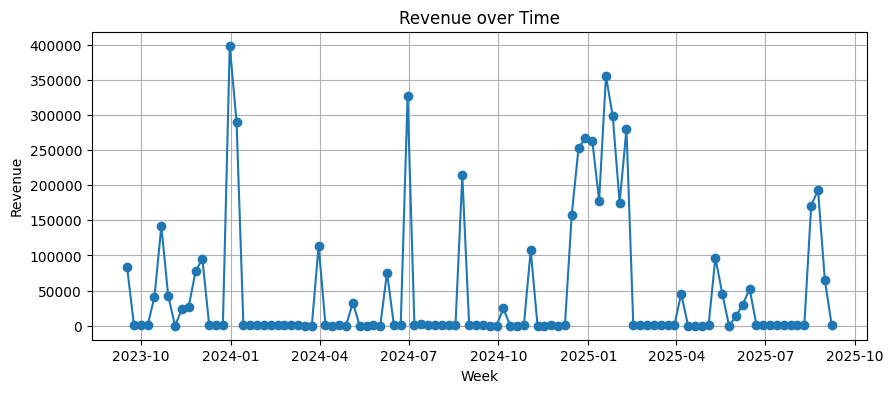

In [3]:
import matplotlib.pyplot as plt

# Make sure week is datetime and sorted
df['week'] = pd.to_datetime(df['week'])
df = df.sort_values('week')

# Plot revenue over time
plt.figure(figsize=(10,4))
plt.plot(df['week'], df['revenue'], marker='o')
plt.title("Revenue over Time")
plt.xlabel("Week")
plt.ylabel("Revenue")
plt.grid(True)
plt.show()


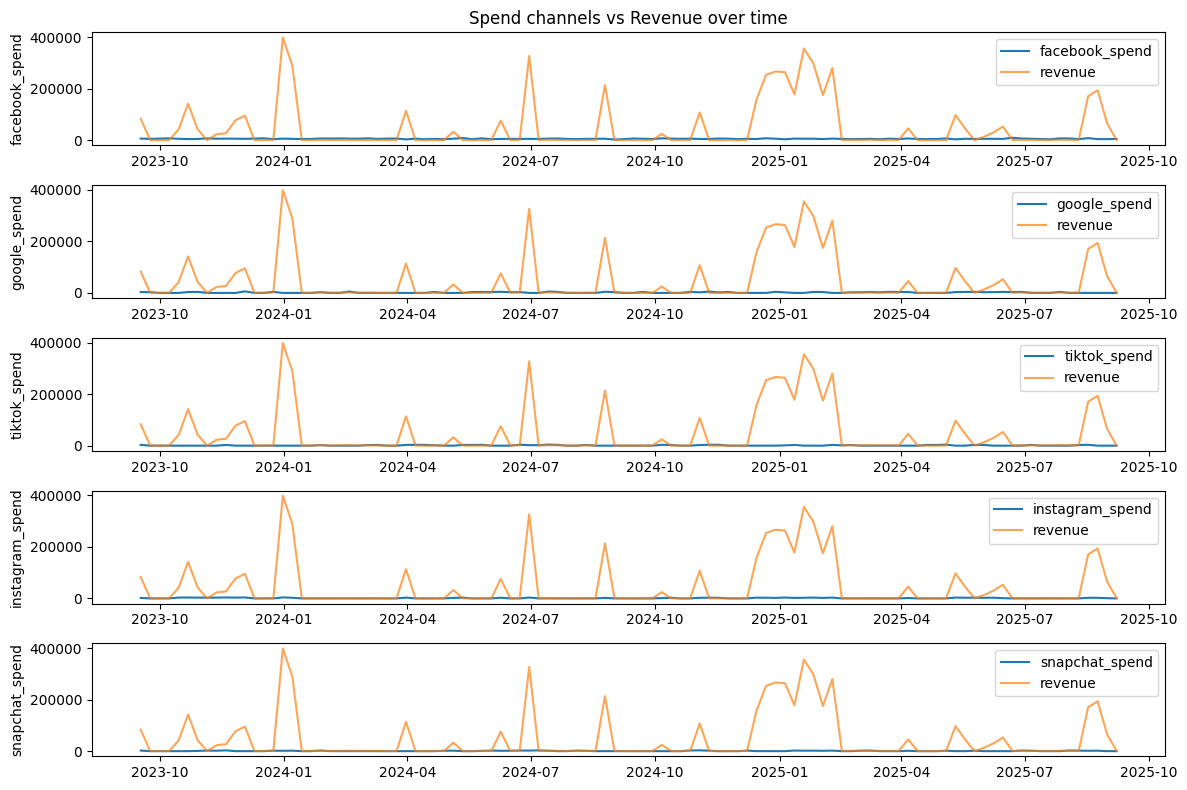

In [4]:
# Pick spend columns
spend_cols = ['facebook_spend', 'google_spend', 'tiktok_spend', 
              'instagram_spend', 'snapchat_spend']

# Plot each spend channel vs revenue
import matplotlib.pyplot as plt

plt.figure(figsize=(12,8))

for i, col in enumerate(spend_cols, 1):
    plt.subplot(len(spend_cols), 1, i)
    plt.plot(df['week'], df[col], label=col, color='tab:blue')
    plt.plot(df['week'], df['revenue'], label='revenue', color='tab:orange', alpha=0.7)
    plt.legend(loc='upper right')
    plt.ylabel(col)
    if i == 1:
        plt.title("Spend channels vs Revenue over time")

plt.tight_layout()
plt.show()


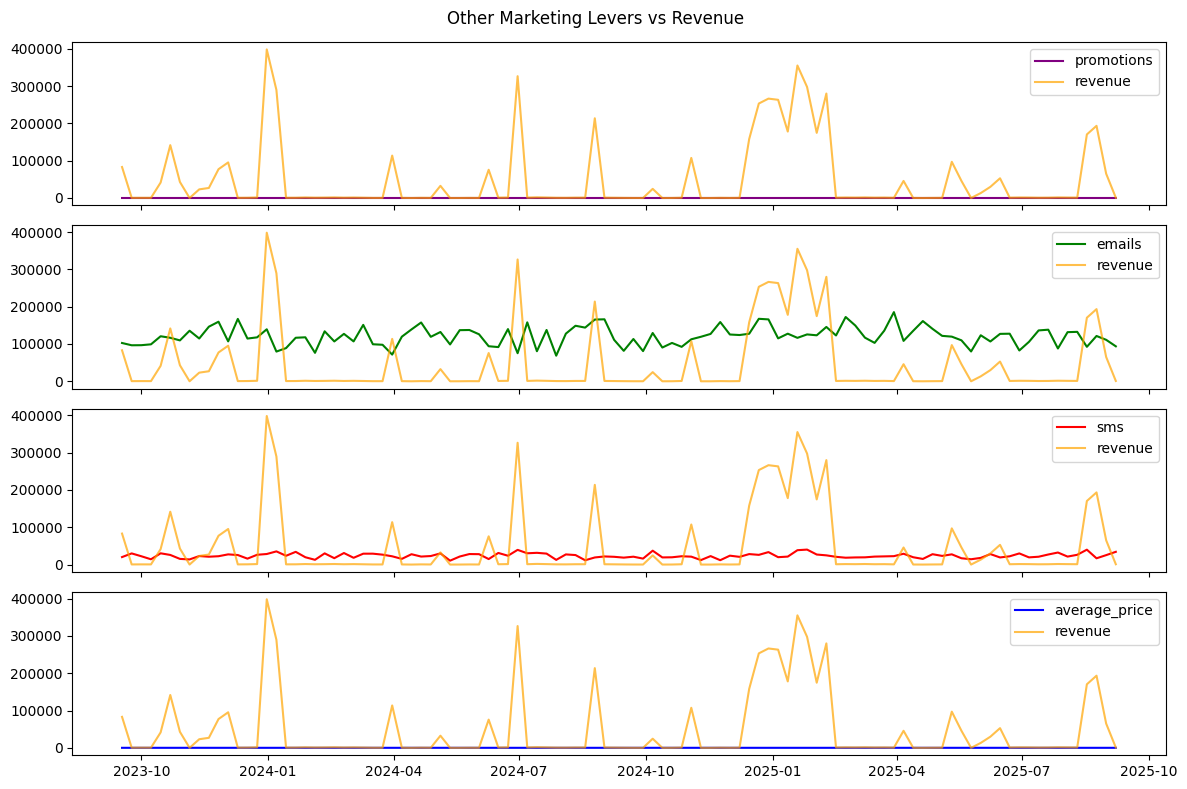

In [5]:
fig, axs = plt.subplots(4, 1, figsize=(12,8), sharex=True)

axs[0].plot(df['week'], df['promotions'], label='promotions', color='purple')
axs[0].plot(df['week'], df['revenue'], label='revenue', color='orange', alpha=0.7)
axs[0].legend(loc='upper right')

axs[1].plot(df['week'], df['emails_send'], label='emails', color='green')
axs[1].plot(df['week'], df['revenue'], label='revenue', color='orange', alpha=0.7)
axs[1].legend(loc='upper right')

axs[2].plot(df['week'], df['sms_send'], label='sms', color='red')
axs[2].plot(df['week'], df['revenue'], label='revenue', color='orange', alpha=0.7)
axs[2].legend(loc='upper right')

axs[3].plot(df['week'], df['average_price'], label='average_price', color='blue')
axs[3].plot(df['week'], df['revenue'], label='revenue', color='orange', alpha=0.7)
axs[3].legend(loc='upper right')

plt.suptitle("Other Marketing Levers vs Revenue")
plt.tight_layout()
plt.show()


Test RMSE: 80779.00
Test R²: -1.13


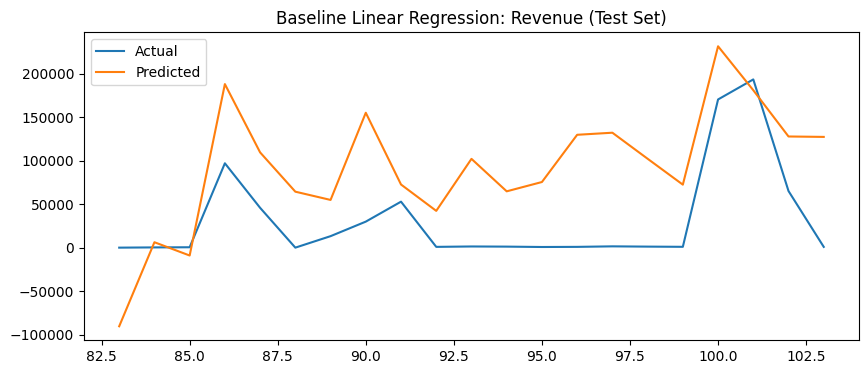

In [6]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score
import numpy as np

# Features and target
X = df[['facebook_spend','google_spend','tiktok_spend',
        'instagram_spend','snapchat_spend',
        'emails_send','sms_send','social_followers',
        'average_price','promotions']]

y = df['revenue']

# Train-test split (time-based: first 80% train, last 20% test)
split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Metrics
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.2f}")

# Compare actual vs predicted visually
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("Baseline Linear Regression: Revenue (Test Set)")
plt.legend()
plt.show()



In [7]:
import numpy as np

def adstock(series, half_life=2):
    """
    Simple exponential adstock transform.
    half_life = weeks until effect halves.
    """
    decay = 0.5 ** (1/half_life)
    res = np.zeros(len(series))
    carry = 0
    for i, x in enumerate(series):
        carry = x + decay * carry
        res[i] = carry
    return res

# Apply adstock to each spend channel
spend_cols = ['facebook_spend','google_spend','tiktok_spend',
              'instagram_spend','snapchat_spend']

for col in spend_cols:
    df[col + "_adstock"] = adstock(df[col].values, half_life=2)

# Check first few rows
df[[col+"_adstock" for col in spend_cols]].head()


,facebook_spend_adstock,google_spend_adstock,tiktok_spend_adstock,instagram_spend_adstock,snapchat_spend_adstock
0,6030.800000,3130.140000,2993.22000,1841.080000,2204.720000
1,9505.859576,4917.343220,2116.52616,1301.840153,1558.972463
2,12614.657767,3477.086736,1496.61000,920.540000,1102.360000
3,16087.070050,2458.671610,1058.26308,650.920076,779.486231
4,16735.566321,1738.543368,748.30500,3697.420000,551.180000


In [8]:
# Apply log transform to adstocked spends
for col in spend_cols:
    ad_col = col + "_adstock"
    sat_col = col + "_sat"
    df[sat_col] = np.log1p(df[ad_col])   # log1p = log(1+x), safe for zero

# Check new saturation columns
df[[col+"_sat" for col in spend_cols]].head()


,facebook_spend_sat,google_spend_sat,tiktok_spend_sat,instagram_spend_sat,snapchat_spend_sat
0,8.704801,8.049152,8.004439,7.518651,7.698809
1,9.159769,8.500727,7.658004,7.172302,7.352423
2,9.442694,8.154238,7.311626,6.826046,7.006115
3,9.685833,7.807783,6.965329,6.479922,6.659917
4,9.725351,7.461378,6.619146,8.215661,6.313874


Test RMSE: 92834.65
Test R²: -1.82


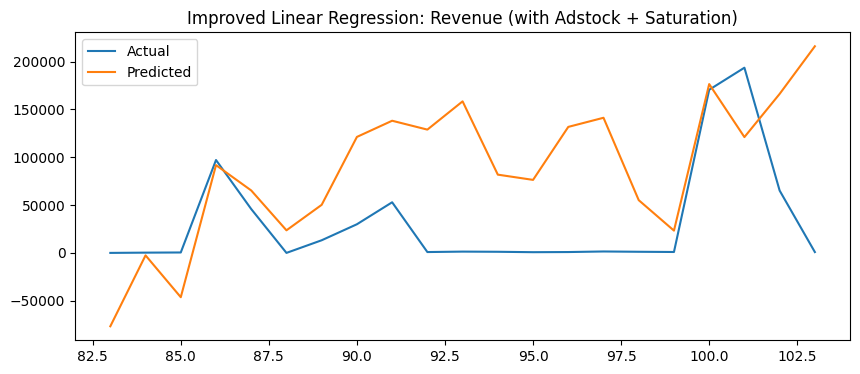

In [9]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score

# Features: saturated spends + controls
X = df[[col+"_sat" for col in spend_cols] + 
       ['emails_send','sms_send','social_followers','average_price','promotions']]

y = df['revenue']

# Train-test split (time-based: first 80% train, last 20% test)
split = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split], X.iloc[split:]
y_train, y_test = y.iloc[:split], y.iloc[split:]

# Fit model
model = LinearRegression()
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)

# Metrics
rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Test RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.2f}")

# Plot actual vs predicted
import matplotlib.pyplot as plt
plt.figure(figsize=(10,4))
plt.plot(y_test.index, y_test.values, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted")
plt.title("Improved Linear Regression: Revenue (with Adstock + Saturation)")
plt.legend()
plt.show()


In [10]:
from sklearn.linear_model import LinearRegression

# Social channels (use the same ones you had before with adstock/saturation if available)
social_features = ['facebook_spend_sat', 'tiktok_spend_sat', 'snapchat_spend_sat', 'instagram_spend_sat']

# Controls (non-media factors)
controls = ['emails_send','sms_send','social_followers','average_price','promotions']

# Stage 1: Google ~ social + controls
X_stage1 = df[social_features + controls]
y_stage1 = df['google_spend']

model_stage1 = LinearRegression()
model_stage1.fit(X_stage1, y_stage1)

# Print coefficients
coef_stage1 = pd.Series(model_stage1.coef_, index=X_stage1.columns)
print("Stage1 coefficients (Google ~ Social + Controls):")
print(coef_stage1.sort_values(ascending=False).round(4))


Stage1 coefficients (Google ~ Social + Controls):
instagram_spend_sat     431.7794
tiktok_spend_sat        112.1986
snapchat_spend_sat       62.8145
promotions               33.7812
social_followers          0.0036
emails_send              -0.0005
sms_send                 -0.0166
average_price           -11.1932
facebook_spend_sat    -1727.0652
dtype: float64
